In [1]:
%matplotlib notebook
import numpy as np
import scipy.linalg as la
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve, lsqr

from numpy.linalg import cond, norm, inv


import pandas as pd

import pickle
import os.path

import warnings
warnings.simplefilter('ignore')

from scipy.optimize import minimize_scalar

from poly_basis import *

from ex2_helper import *

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def rbf(r):
    return np.exp(-eps * r**2)
def rbfd(r):
    return -2*eps*r*rbf(r)
def rbfd_div_r(r):
    return -2*eps*rbf(r)
def rbfd2(r):
    return 2*eps*rbf(r)*(2*eps*r**2-1)


def rbfL(r):
    return rbfd2(r) + rbfd_div_r(r) *2

def grad_rbf(node, center):
    r = dist(node, center)
    return rbfd_div_r(r) * (node - center)

def rbf_x(node, center, xi):
    x = (node-center)[xi]
    r = dist(node, center)
    return rbfd_div_r(r)*x

def rbf_xx(node, center, xi):
    x = (node-center)[xi]
    r = dist(node, center)
    if r==0:
        return -2
    return rbfd_div_r(r)* (1 - (x/r)**2) + (x/r)**2 * rbfd2(r)

def rbf_xy(node, center, xi, yi):
    x = (node-center)[xi]
    y = (node-center)[yi]
    r = dist(node, center)
    if r == 0:
        return 0
    return (x*y/r**2) * (rbfd2(r) - rbfd_div_r(r))


def foo1(node):
    return -2*node[0]
def exact1(node):
    return node[0]

# l=2
def foo2(node):
    return -6 * (node[0]**2 - node[1]**2)
def exact2(node):
    return (node[0]**2 - node[1]**2)

# l=3
def foo3(node):
    return -(node[0]**2 - node[1]**2) * node[2] * 12

def exact3(node):
    return (node[0]**2 - node[1]**2) * node[2]

# l=4
def foo4(node):
    return -(3*node[0]**2 - node[1]**2)*node[1]*node[2] * 20
def exact4(node):
    return (3*node[0]**2 - node[1]**2)*node[1]*node[2]

In [3]:
n = 50
k = n
delta = .2
gamma = .02
my_node = n//4
eps = 2

foo, exact = foo3, exact3

# Low Order Method

cond A: 3.81696e+10
cond B: 3.81696e+10
0.04301087467112483
0.038156375882982714


<IPython.core.display.Javascript object>


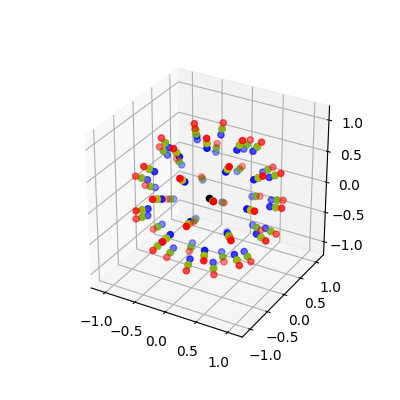

In [4]:
nodes = gen_spiral_nodes(n)
tree = cKDTree(np.array(nodes))
stencil = tree.query(nodes[my_node], k)[1]
nn = np.array([nodes[i] for i in stencil]) #nodes in the stencil

# calculate smallest distance between nodes
dist_mat = [[dist(x,y) for x in nn] for y in nn]
d = np.min(np.diag([10**5]*k) + dist_mat)*delta

# form X^+ and X^-
nnp = nn*(1+d)
nnm = nn*(1-d)
# is the array containing all the X, followed by X^+, followed by X^-
nna = np.block([[nn],[nnp],[nnm]])

# reconstruct surface as the zero-isosurface of an RBF interpolant
A = np.array([[rbf(dist(x,y)) for x in nna] for y in nna])
#fsa = np.array([exact(x) for x in nn]*3)
f_level = [0.0]*k + [1.0]*k+ [-1.0]*k
f_level = np.array(f_level)
cs = la.solve(A,f_level)

grad_s = np.zeros((k, 3))
for c, y in zip(cs, nna):
    grad_s += [c*grad_rbf(x,y) for x in nn]

normals = np.array([gs/norm(gs) for gs in grad_s])
#normals = nn

yyp = nn + normals*gamma*d
yym = nn - normals*gamma*d
yya = np.block([[nn],[yyp],[yym]])

A = np.array([[ rbf(dist(x,y)) for y in nna] for x in yya])
B = np.array([[rbfL(dist(x,y)) for y in nna] for x in nna])

print('cond A: %g' % cond(A))
print('cond B: %g' % cond(A))

fs = np.array([exact(x) for x in nn]*3)
us = B@la.solve(A, fs)

#D = B * inv(A)
#D = D[:k, :k] + D[:k, k:2*k] + D[:k, 2*k:3*k]


ds = np.array([foo(x) for x in nn])

print(norm(us[:k] - ds)/norm(ds))
print(((us)[0] - foo(nn[0]))/foo(nn[0]))

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(nnp[:,0], nnp[:,1], nnp[:,2], '.', color='r')
ax.scatter(yyp[:,0], yyp[:,1], yyp[:,2], '.', color='y')
ax.scatter( nn[:,0],  nn[:,1],  nn[:,2], '.', color='g')
ax.scatter(yym[:,0], yym[:,1], yym[:,2], '.', color='c')
ax.scatter(nnm[:,0], nnm[:,1], nnm[:,2], '.', color='b')
ax.scatter(0, 0, 0, '.', color='k')

plt.show()

# High Order Method

In [24]:
n = 200
k = n
delta = .2
my_node = 0#n//4
eps = 1

foo, exact = foo3, exact3

cond A: 3.54584e+20
cond B: 3.54584e+20
total rel L_2 error: 5.46974e-09
rel L_2 err at center: -2.43601e-08
L at center: 0.087822
approx at center: 0.087822


<IPython.core.display.Javascript object>


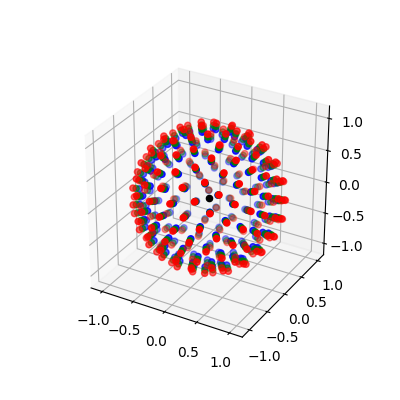

In [25]:
nodes = gen_spiral_nodes(n)
tree = cKDTree(np.array(nodes))
stencil = tree.query(nodes[my_node], k)[1]
nn = np.array([nodes[i] for i in stencil]) #nodes in the stencil

# calculate smallest distance between nodes
dist_mat = [[dist(x,y) for x in nn] for y in nn]
d = np.min(np.diag([10**5]*k) + dist_mat)*delta

# form X^+ and X^-
nnp = nn*(1+d)
nnm = nn*(1-d)
# is the array containing all the X, followed by X^+, followed by X^-
nna = np.block([[nn],[nnp],[nnm]])

# reconstruct surface as the zero-isosurface of an RBF interpolant
A = np.array([[rbf(dist(x,y)) for x in nna] for y in nna])
#fsa = np.array([exact(x) for x in nn]*3)
f_level = [0.0]*k + [1.0]*k+ [-1.0]*k
f_level = np.array(f_level)
cs = la.solve(A,f_level)

# construct normal gradient
S_x = np.zeros(k)
S_y = np.zeros(k)
S_z = np.zeros(k)
S_xx = np.zeros(k)
S_xy = np.zeros(k)
S_xz = np.zeros(k)
S_yy = np.zeros(k)
S_yz = np.zeros(k)
S_zz = np.zeros(k)
for c, y in zip(cs, nna):
    S_x  += np.array([ c*rbf_x(x,y,0)    for x in nn ])
    S_y  += np.array([ c*rbf_x(x,y,1)    for x in nn ])
    S_z  += np.array([ c*rbf_x(x,y,2)    for x in nn ])
    S_xx += np.array([ c*rbf_xx(x,y,0)   for x in nn ])
    S_xy += np.array([ c*rbf_xy(x,y,0,1) for x in nn ])
    S_xz += np.array([ c*rbf_xy(x,y,0,2) for x in nn ])
    S_yy += np.array([ c*rbf_xx(x,y,1)   for x in nn ])
    S_yz += np.array([ c*rbf_xy(x,y,1,2) for x in nn ])
    S_zz += np.array([ c*rbf_xx(x,y,2)   for x in nn ])
    
A = np.array([[ rbf(dist(x,y)) for y in nna] for x in nn])
  
nabla_n  = np.array([s_x*np.array([rbf_x(x,y,0) for y in nna]) for s_x, x in zip(S_x, nn)])
nabla_n += np.array([s_y*np.array([rbf_x(x,y,1) for y in nna]) for s_y, x in zip(S_y, nn)])
nabla_n += np.array([s_z*np.array([rbf_x(x,y,2) for y in nna]) for s_z, x in zip(S_z, nn)])

nabla2_n  = np.array([s_x**2 * np.array([rbf_xx(x,y,0) for y in nna]) for s_x, x in zip(S_x, nn)])
nabla2_n += np.array([s_y**2 * np.array([rbf_xx(x,y,1) for y in nna]) for s_y, x in zip(S_y, nn)])
nabla2_n += np.array([s_z**2 * np.array([rbf_xx(x,y,2) for y in nna]) for s_z, x in zip(S_z, nn)])
nabla2_n += np.array([2*s_x*s_y * np.array([rbf_xy(x,y,0,1) for y in nna]) for s_x, s_y, x in zip(S_x, S_y, nn)])
nabla2_n += np.array([2*s_x*s_z * np.array([rbf_xy(x,y,0,2) for y in nna]) for s_x, s_z, x in zip(S_x, S_z, nn)])
nabla2_n += np.array([2*s_y*s_z * np.array([rbf_xy(x,y,1,2) for y in nna]) for s_y, s_z, x in zip(S_y, S_z, nn)])
nabla2_n += np.array([(s_x*s_xx + s_y*s_xy + s_z*s_xz) * np.array([
                rbf_x(x,y,0) for y in nna]) for s_x, s_xx, s_y, s_xy, s_z, s_xz, x 
                      in zip(S_x, S_xx, S_y, S_xy, S_z, S_xz, nn)])
nabla2_n += np.array([(s_x*s_xy + s_y*s_yy + s_z*s_yz) * np.array([
                rbf_x(x,y,1) for y in nna]) for s_x, s_xy, s_y, s_yy, s_z, s_yz, x 
                      in zip(S_x, S_xy, S_y, S_yy, S_z, S_yz, nn)])
nabla2_n += np.array([(s_x*s_xz + s_y*s_yz + s_z*s_zz) * np.array([
                rbf_x(x,y,2) for y in nna]) for s_x, s_xz, s_y, s_yz, s_z, s_zz, x 
                      in zip(S_x, S_xz, S_y, S_yz, S_z, S_zz, nn)])


A = np.block([[A], [nabla_n], [nabla2_n]])
B = np.array([[rbfL(dist(x,y)) for y in nna] for x in nna])

print('cond A: %g' % cond(A))
print('cond B: %g' % cond(A))

fs = np.array([exact(x) for x in nn] + [0]*2*k)
us = B@la.solve(A, fs)


ds = np.array([foo(x) for x in nn])
err_total = norm(us[:k] - ds)/norm(ds)
rel_err_center = (us[0] - foo(nn[0]))/foo(nn[0])
print('total rel L_2 error: %g' % err_total)
print('rel L_2 err at center: %g' % rel_err_center)
print('L at center: %f' % ds[0])
print('approx at center: %f' % us[0])

# plot points
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(nnp[:,0], nnp[:,1], nnp[:,2], '.', color='r')
ax.scatter( nn[:,0],  nn[:,1],  nn[:,2], '.', color='g')
ax.scatter(nnm[:,0], nnm[:,1], nnm[:,2], '.', color='b')
ax.scatter(0, 0, 0, '.', color='k')

plt.show()

In [19]:
print('total rel L_2 error: %g' % err_total)
print('rel L_2 err at center: %g' % rel_err_center)
print('L at center: %f' % ds[0])
print('approx at center: %f' % us[0])

total rel L_2 error: 5.46974e-09
rel L_2 err at center: -2.43601e-08
L at center: 0.087822
approx at center: 0.087822
